# Heart Failure Prediction Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import chi2_contingency

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import umap
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

## EDA

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Descriptive Analytics

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
data.shape

(918, 12)

In [6]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

#### Univariate analisis

###### Numerical Features

In [7]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease']

In [8]:
def plot_variable_distribution(variable_name): 
    plt.figure(figsize=(20, 10))
    sns.histplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

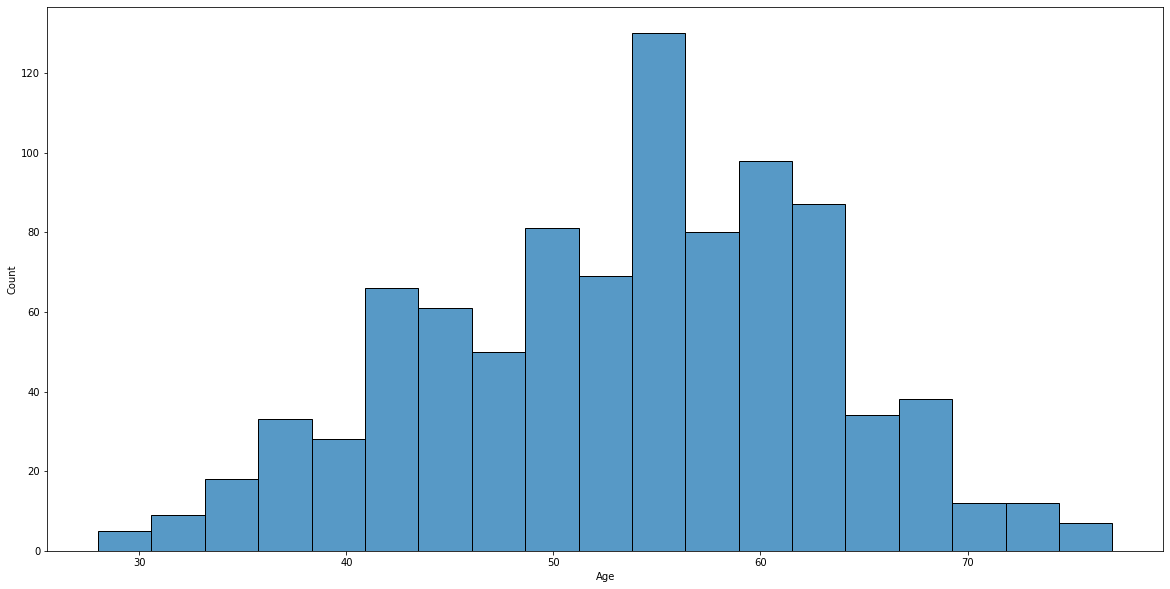

excess kurtosis of normal distribution (should be 0): -0.3905684960842244
skewness of normal distribution (should be 0): -0.19561273124487544


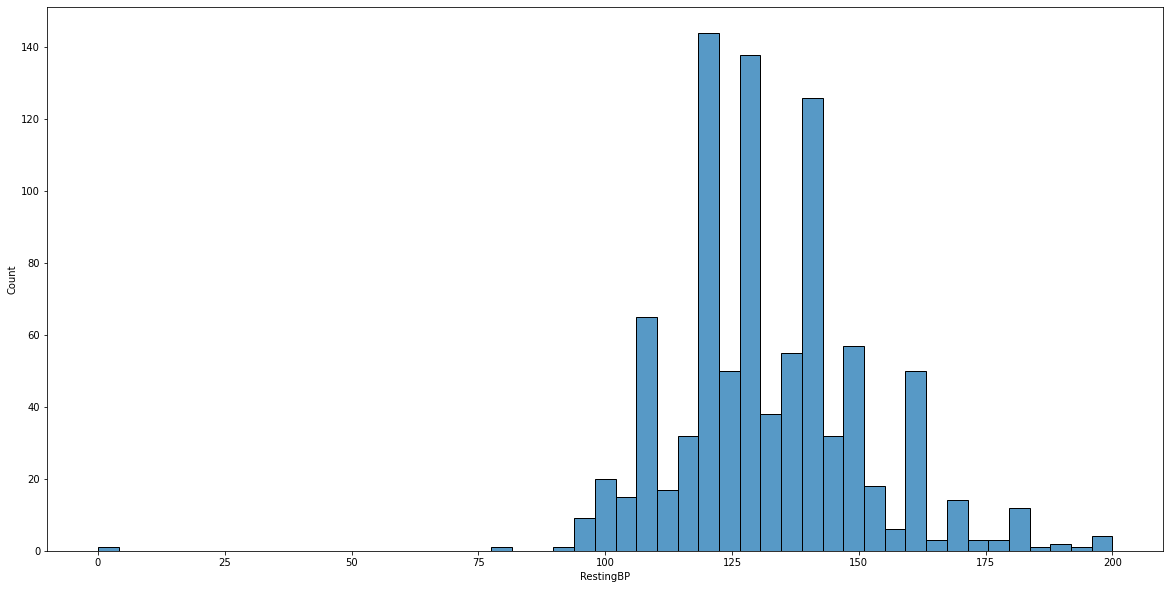

excess kurtosis of normal distribution (should be 0): 3.2469319615478724
skewness of normal distribution (should be 0): 0.17954532149156327


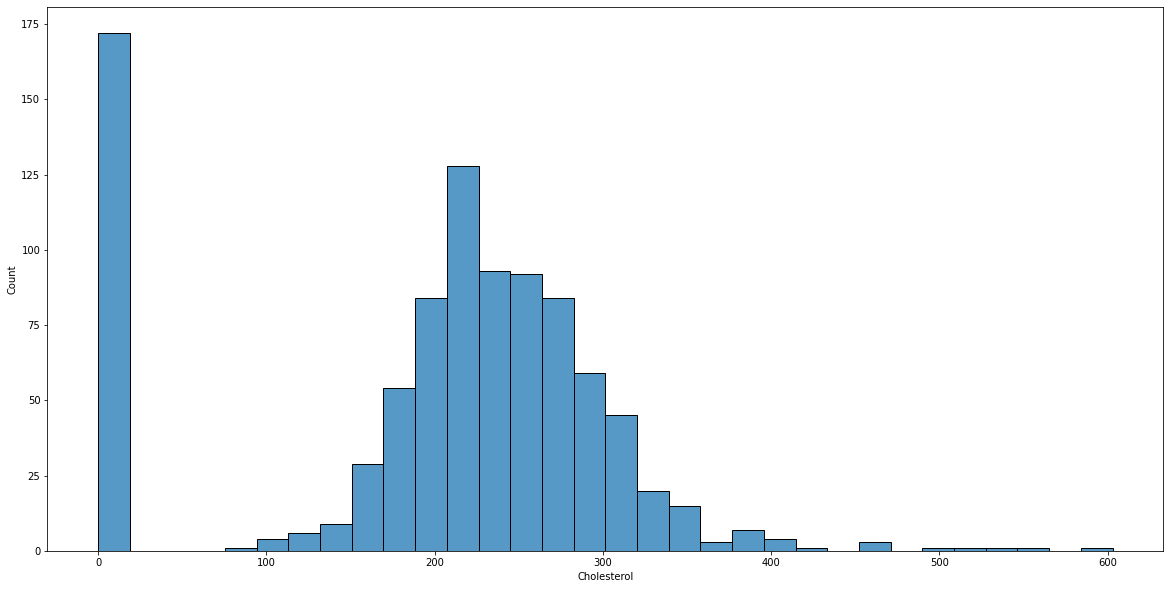

excess kurtosis of normal distribution (should be 0): 0.11103677697582448
skewness of normal distribution (should be 0): -0.6090891046626045


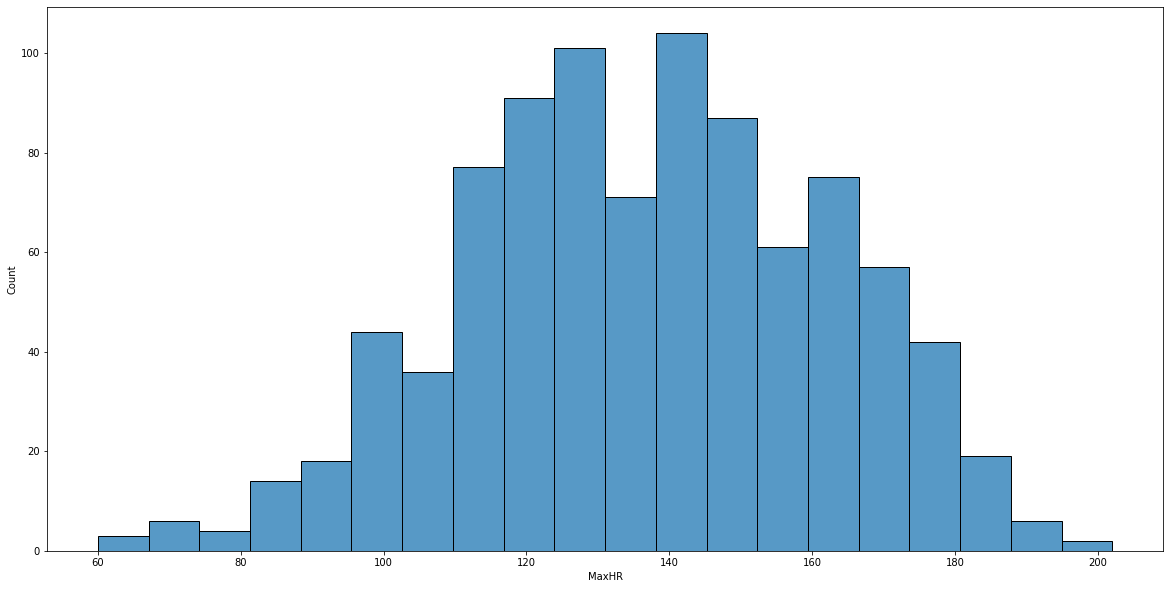

excess kurtosis of normal distribution (should be 0): -0.4523389391469048
skewness of normal distribution (should be 0): -0.14412342991429325


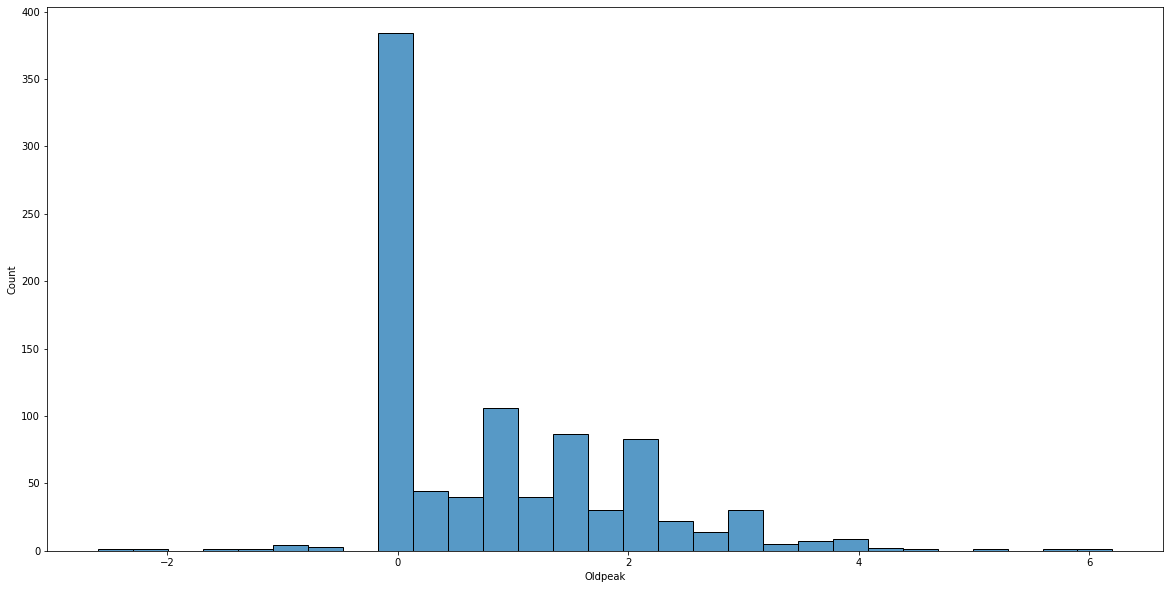

excess kurtosis of normal distribution (should be 0): 1.189992199237265
skewness of normal distribution (should be 0): 1.0211999031135828


In [9]:
for numerical_feature in numerical_features:
    plot_variable_distribution(numerical_feature)
    print( 'excess kurtosis of normal distribution (should be 0): {}'.format(kurtosis(data[f'{numerical_feature}'])))
    print( 'skewness of normal distribution (should be 0): {}'.format(skew(data[f'{numerical_feature}'])))

###### Categorical Features

In [10]:
def plot_categorical_feature_distribution(variable_name):
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=f"{variable_name}", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)
    plt.xlabel(f"{column}")
    plt.savefig(f"../results/EDA/{variable_name}_distribution.png")
    plt.show()
    plt.close()

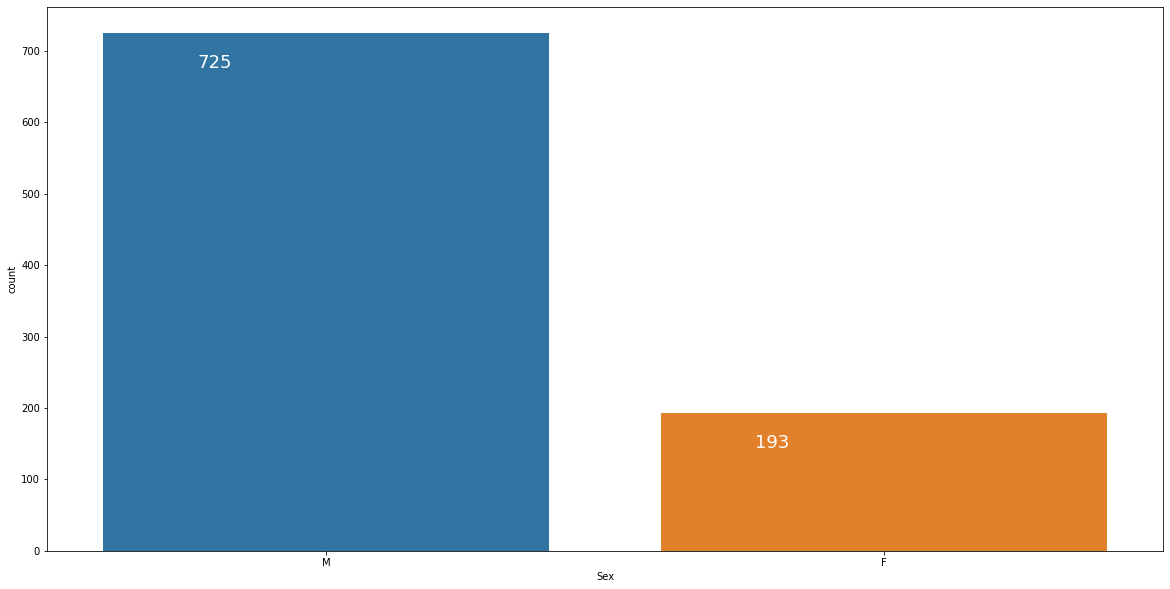

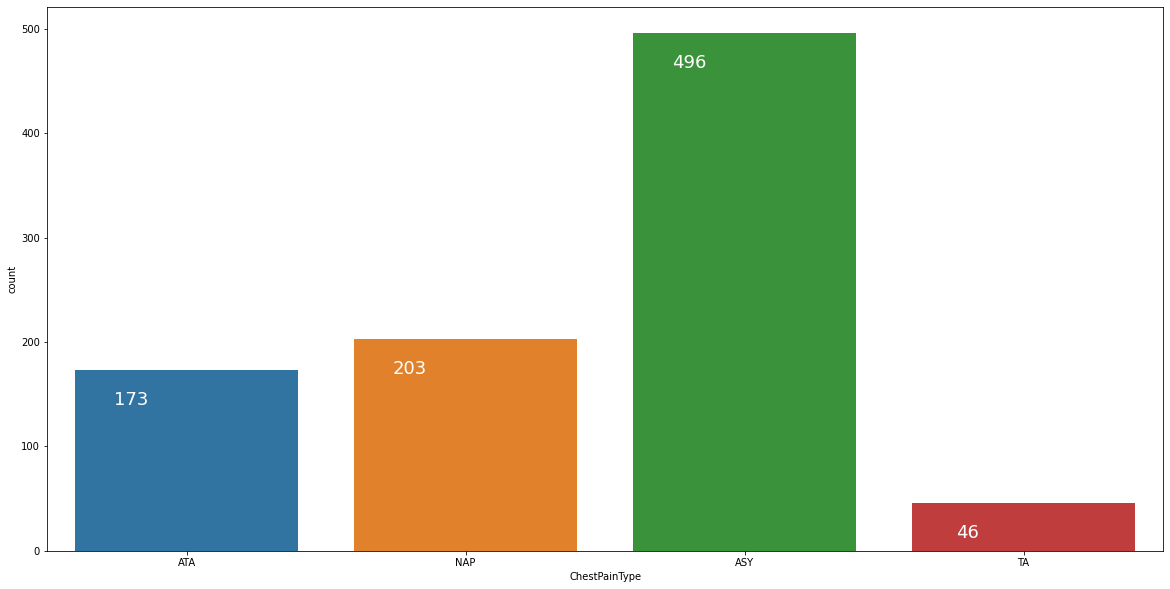

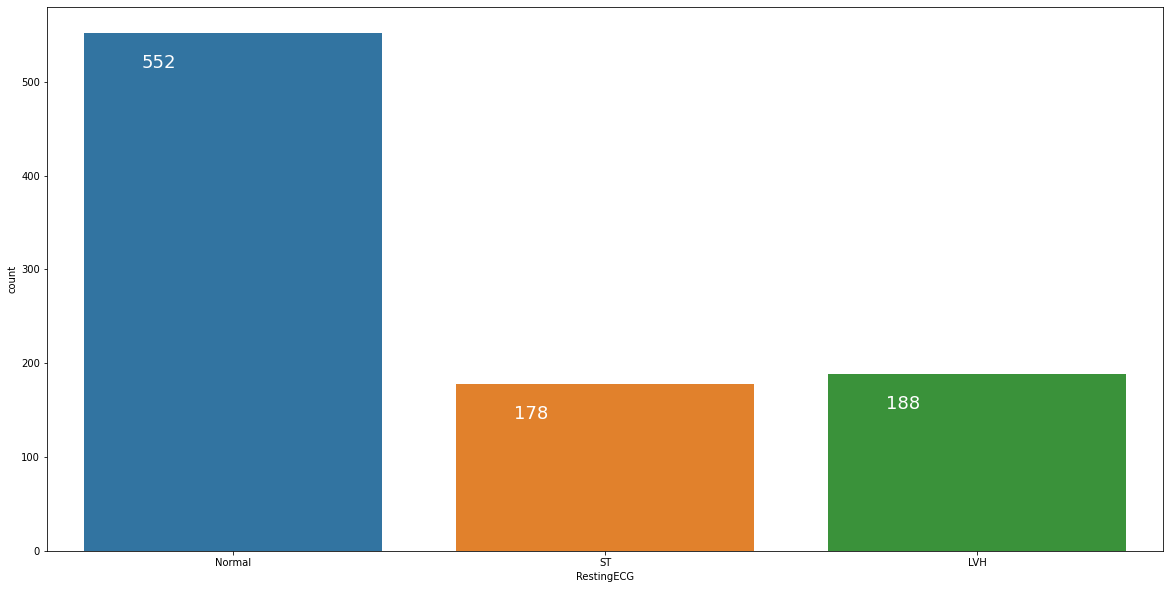

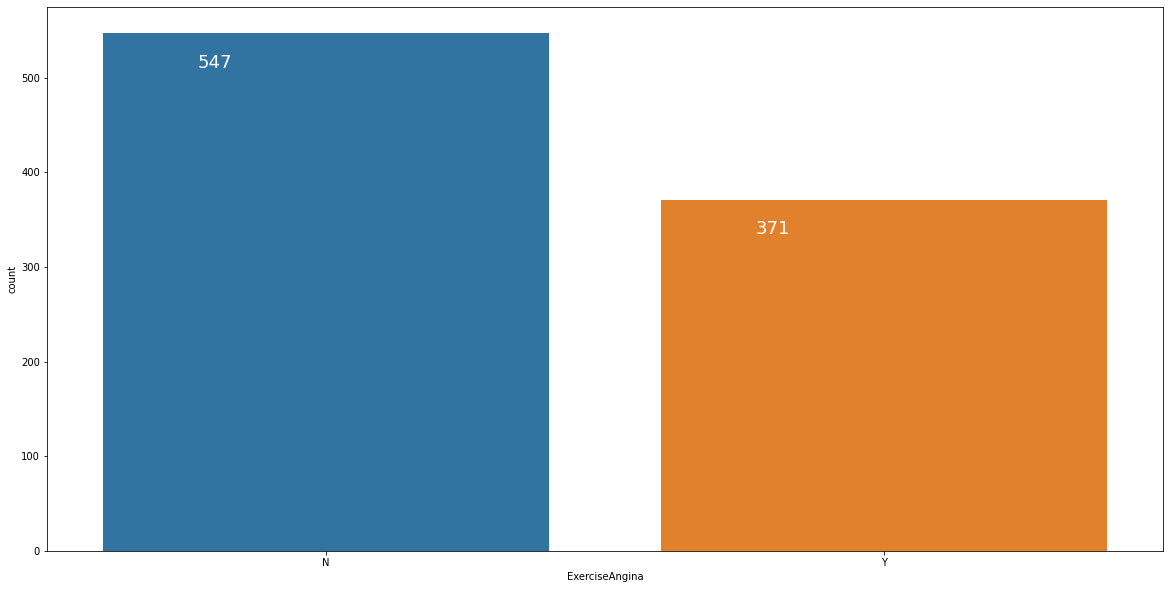

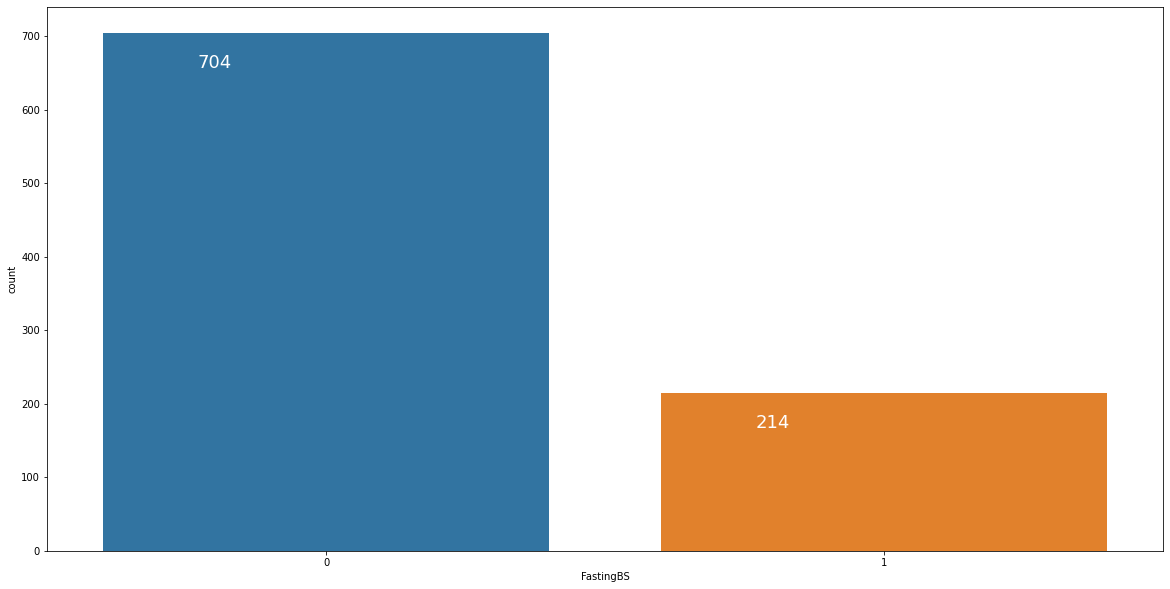

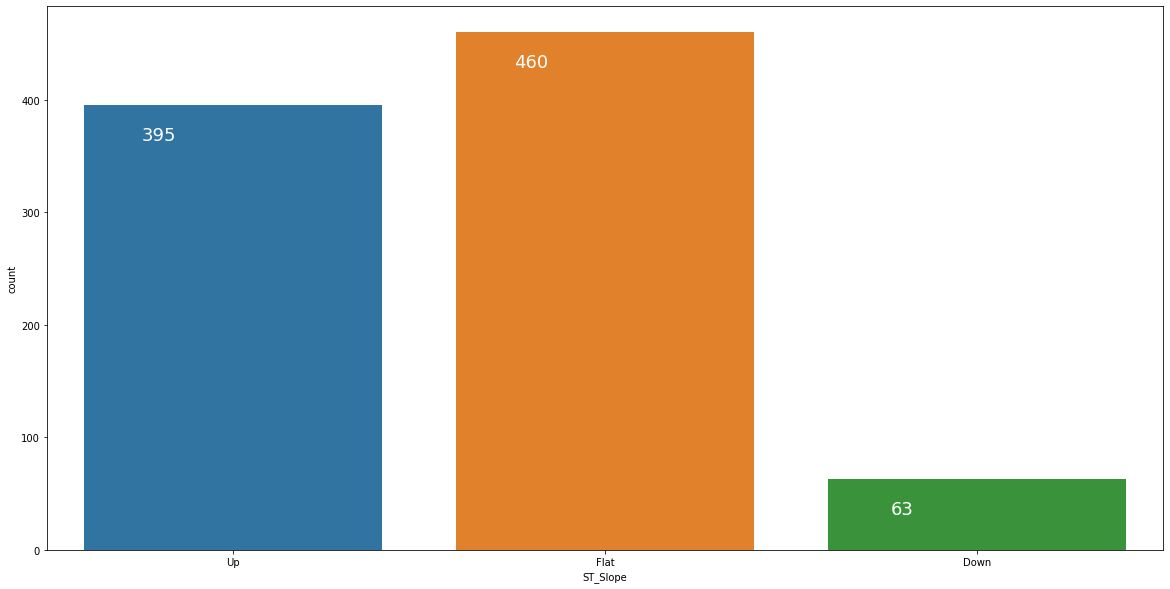

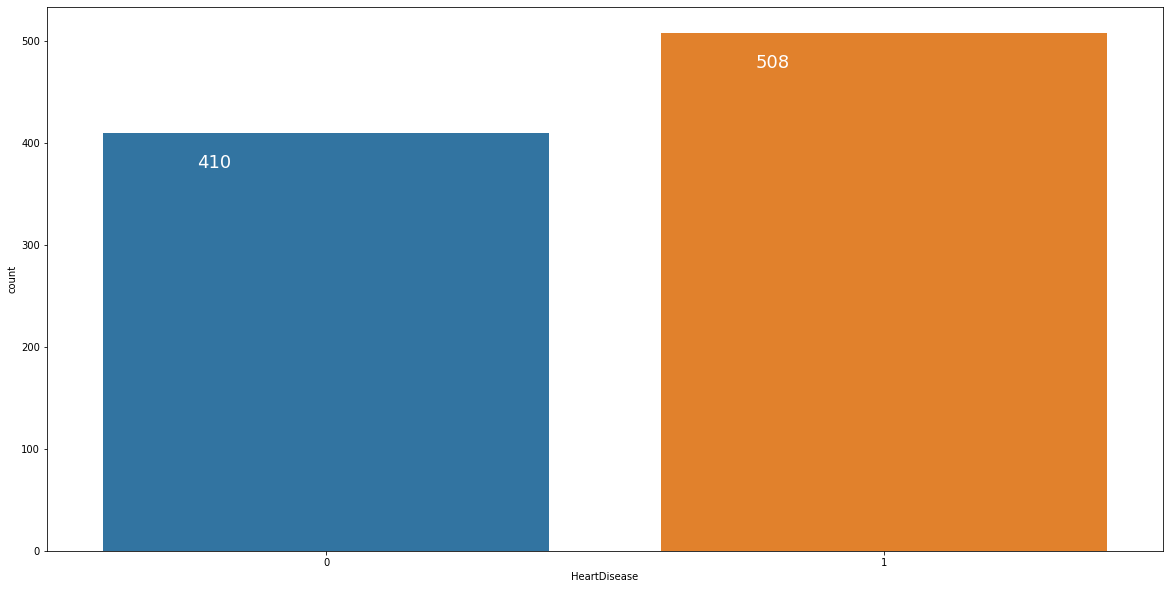

In [11]:
for column in categorical_features: 
    plot_categorical_feature_distribution(column)

We can conclude that the dataset is not imbalaced, since there is no minorty class and we have a almost 50 / 50 ratio between those how suffered a heart failure and those that no

In [12]:
symetric_distribution_features = ['Age', 'Cholesterol', 'MaxHR']

In [13]:
asymetric_distribution_features = ['RestingBP', 'Oldpeak']

In [14]:
# Dataset 1 is the raw dataset, variables will not have any modification in here
dataset_1 = data.copy()

### Missing Values

<AxesSubplot:>

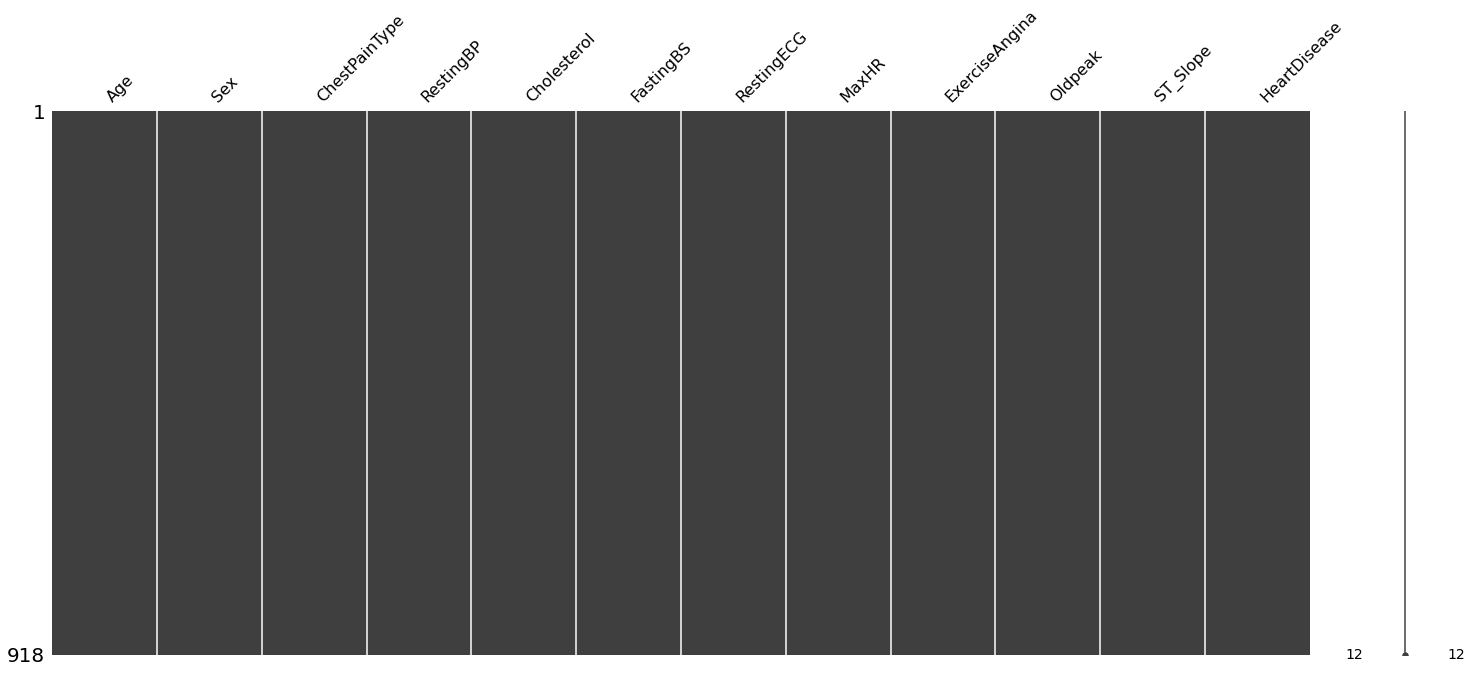

In [15]:
msno.matrix(data)

<AxesSubplot:>

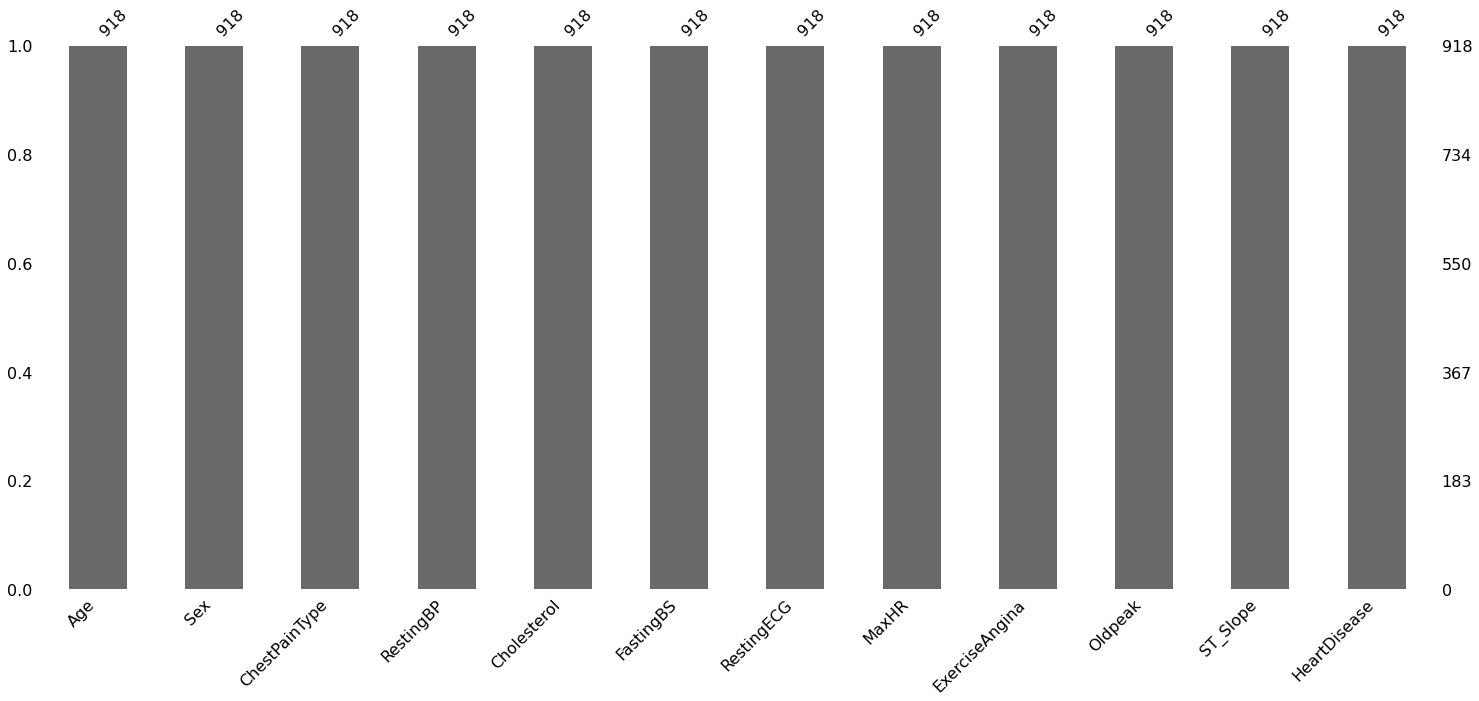

In [16]:
msno.bar(data)

There are no missing values in this dataset. But there are some anomalies in the cholesterol feature.

In [17]:
# Count number of zeros in all columns of Dataframe to detect possible wrong values
for column_name in data.columns:
    column = data[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print(f'Count of zeros in column: {column_name} is {count}, {count/data.shape[0]*100} % of the data ')

Count of zeros in column: Age is 0, 0.0 % of the data 
Count of zeros in column: Sex is 0, 0.0 % of the data 
Count of zeros in column: ChestPainType is 0, 0.0 % of the data 
Count of zeros in column: RestingBP is 1, 0.10893246187363835 % of the data 
Count of zeros in column: Cholesterol is 172, 18.736383442265794 % of the data 
Count of zeros in column: FastingBS is 704, 76.68845315904139 % of the data 
Count of zeros in column: RestingECG is 0, 0.0 % of the data 
Count of zeros in column: MaxHR is 0, 0.0 % of the data 
Count of zeros in column: ExerciseAngina is 0, 0.0 % of the data 
Count of zeros in column: Oldpeak is 368, 40.08714596949891 % of the data 
Count of zeros in column: ST_Slope is 0, 0.0 % of the data 
Count of zeros in column: HeartDisease is 410, 44.66230936819172 % of the data 


#### Cholesterol

In [18]:
number_of_zeroes = data['Cholesterol'][data['Cholesterol'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in Cholesterol')

There are 172 0´s in Cholesterol


#### Resting BP

In [19]:
number_of_zeroes = data['RestingBP'][data['RestingBP'] == 0].count()
print(f'There are {number_of_zeroes} 0´s in RestingBP')

There are 1 0´s in RestingBP


#### Mean Inputation

In [20]:
dataset_2_1 = data.copy()
dataset_2_1['Cholesterol']=dataset_2_1['Cholesterol'].mask(dataset_2_1['Cholesterol']==0).fillna(dataset_2_1['Cholesterol'].mean())
dataset_2_1['RestingBP']=dataset_2_1['RestingBP'].mask(dataset_2_1['RestingBP']==0).fillna(dataset_2_1['RestingBP'].mean())

#### Regression Inputation

In [21]:
dataset_2_2 = data.copy()
dataset_2_2['Cholesterol']=dataset_2_2['Cholesterol'].mask(dataset_2_2['Cholesterol']==0)
dataset_2_2['RestingBP']=dataset_2_2['RestingBP'].mask(dataset_2_2['RestingBP']==0)
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(dataset_2_2)
dataset_2_2 = pd.DataFrame(imputed, columns=dataset_2_2.columns)

ValueError: could not convert string to float: 'M'

### Outlier Detection

In [ ]:
def mean_3_std(variable_name):
    data_mean, data_std = np.mean(data[f'{variable_name}']), np.std(data[f'{variable_name}'])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, Upper outliers {outliers_upper}, boundaries {lower}, {upper}')

In [ ]:
def plot_intercuartile_range(variable_name):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=data, x=f"{variable_name}")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/{variable_name}_outliers.png")
    plt.show()
    plt.close()

In [ ]:
for symetric_distribution_feature in symetric_distribution_features:
    mean_3_std(symetric_distribution_feature)

In [ ]:
def iqr(variable_name):
    q75, q25 = np.percentile(data[f'{variable_name}'], [75 ,25])
    iqr = q75 - q25
    lower = q25 - iqr*1.5
    upper = q75 + iqr*1.5
    outliers_lower = [x for x in data[f'{variable_name}'] if x < lower]
    outliers_upper = [x for x in data[f'{variable_name}'] if x > upper]
    print(f'Variable {variable_name}: Lower outliers {outliers_lower}, {len(outliers_lower)}, Upper outliers {outliers_upper}, {len(outliers_upper)}, boundaries {lower}, {upper}')

In [ ]:
for asymetric_distribution_feature in asymetric_distribution_features:
    iqr(asymetric_distribution_feature)

In [ ]:
for numerical_feature in numerical_features:
    plot_intercuartile_range(numerical_feature)

### Multivariate Analysis

The target column in this case is very clear, HeartDisease. We already know that it is not balanced, but know we will try to detect any pattern. 

#### Numerical features: Plots

In [ ]:
def distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.violinplot(x="HeartDisease", y=f"{variable_name}",
                    data=data, palette="Set2", split=True,
                    scale="count")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/violin_{variable_name}.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(x="HeartDisease", y=f"{variable_name}", data=data, palette="Set2")
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_target.png")
    plt.show()
    plt.close()

In [ ]:
for numerical_feature in numerical_features: 
    distribution_acording_to_target_value(numerical_feature)
    

#### Categorical features: Plots

In [ ]:
def categorical_distribution_acording_to_target_value(variable_name):
    plt.figure(figsize=(20, 10))
    plt.title(f"Distribution of {variable_name}")
    ax = sns.countplot(x=f"{variable_name}", hue="HeartDisease", data=data)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=14)
    plt.xlabel(f"{variable_name}")
    plt.savefig(f"../results/EDA/distribution_{variable_name}_targetb.png")
    plt.show()
    plt.close()

In [ ]:
for categorical_feature in categorical_features[:-1]: 
    categorical_distribution_acording_to_target_value(categorical_feature)

#### ANOVA analysis

The idea of this analysis is to see if there is any connection between the target values and the different numerical variables.

In [ ]:
for numerical_feauture in numerical_features:
    none_relevant_features = []
    p_value = 0.05
    anova_test = stats.f_oneway(data[f'{numerical_feauture}'][data['HeartDisease'] == 0], data[f'{numerical_feauture}'][data['HeartDisease'] == 1])
    if anova_test[1] > p_value:
        none_relevant_features.append(feature)

#### Chi analysis

The idea of this analysis is to see if there is any connection between the target values and the different categorical variables.

In [ ]:
p_value = 0.05
for categorical_feature in categorical_features:
    ct = pd.crosstab(data[f'{categorical_feature}'], data['HeartDisease'], margins=True)
    ct = ct.drop("All", axis=1).drop("All", axis=0)
    obs = np.array(ct.values)
    if stats.chi2_contingency(obs)[0:3][1] > p_value:
        none_relevant_features.append(f'{categorical_feature}')
print(none_relevant_features) 

#### Decistion Tree: Feature understanding

The idea is to train a decision tree to understand what are the variables that affect most the target value, or if any variable does not affect it

In [ ]:
# Encoding:
decision_tree = data.copy()

object_cols = decision_tree.loc[:, data.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    decision_tree[f'{column}'] = LabelEncoder().fit_transform(decision_tree[f'{column}'])
    
features_for_importance=decision_tree.columns.to_list()
features_for_importance.remove('HeartDisease')

In [ ]:
clasifier = DecisionTreeClassifier()
clasifier.fit(decision_tree.loc[:, decision_tree.columns != 'HeartDisease'], decision_tree['HeartDisease'])

In [ ]:
importances = clasifier.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(features_for_importance)[indices])
plt.xlabel('Relative Importance')

#### Correlations

In [ ]:
plt.figure(figsize=(20, 10))
matrix = np.triu(data[numerical_features].corr())
sns.heatmap(data[numerical_features].corr(), annot=True, mask=matrix)
plt.show()
plt.close()

In [ ]:
data.corr().unstack().sort_values().drop_duplicates().head(10)

In [ ]:
data.corr().unstack().sort_values().drop_duplicates().tail(10)

#### Unsupervised learning for hidden patterns: UMAP

In [ ]:
scaler = StandardScaler()

data_clustering = data.copy()

object_cols = data_clustering.loc[:, data_clustering.dtypes == 'O']
object_type_columns = [col for col in object_cols.columns]

for column in object_type_columns:
    data_clustering[f'{column}'] = LabelEncoder().fit_transform(data_clustering[f'{column}'])
data_clustering = scaler.fit_transform(data_clustering.loc[:, data.columns != 'HeartDisease'])

In [ ]:
umap_embeding = umap.UMAP(random_state=42).fit_transform(data_clustering)

In [ ]:
for n_of_components in range(0,12):
    pca = PCA(n_components=n_of_components)
    pca_embeding = pca.fit_transform(data_clustering)
    print(f'Number of Components :{n_of_components}, {pca.explained_variance_ratio_.sum()}')

In [ ]:
pca = PCA(n_components=2)
pca_embeding = pca.fit_transform(data_clustering)
print(pca.explained_variance_ratio_.sum())

In [ ]:
kmeans_true_labels = cluster.KMeans(n_clusters=2).fit_predict(data_clustering)
kmeans_umap_labels = cluster.KMeans(n_clusters=2).fit_predict(umap_embeding[:, 0].reshape(-1, 1), umap_embeding[:, 1].reshape(-1, 1))
kmeans_pca_labels = cluster.KMeans(n_clusters=2).fit_predict(pca_embeding[:, 0].reshape(-1, 1), pca_embeding[:, 1].reshape(-1, 1))

In [ ]:
def scatter_plot(axis1, axis2, color, title, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.scatter(axis1, axis2, c=color, cmap='Pastel1')
    plt.title(f'{title}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.show()
    plt.close()

In [ ]:
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')
scatter_plot(axis1=pca_embeding[:, 0].reshape(-1, 1),
            axis2=pca_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='Principal Component 1',
            ylabel='Principal Component 2')

In [ ]:
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=data['HeartDisease'],
            title='Heart failure in PCA', 
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_true_labels,
            title='K-means represented in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_pca_labels,
            title='K-means calculated with in PCA',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')
scatter_plot(axis1=umap_embeding[:, 0].reshape(-1, 1),
            axis2=umap_embeding[:, 1].reshape(-1, 1),
            color=kmeans_umap_labels,
            title='K-means calculated with in UMAP',
            xlabel='UMAP embedding 1',
            ylabel='UMAP embedding 2')

In [ ]:
def get_results(label, method, method_name):
    """
    df = pd.DataFrame(list(zip(label, method)), columns =['Label', f'{method_name}'])
    print(df)
    print(df.groupby([f'{method_name}']).count())
    print(df.groupby([f'Label', f'{method_name}']))
    """
    print(method_name)
    cm = confusion_matrix(label, method)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [ ]:
get_results(data['HeartDisease'], kmeans_true_labels, 'k means')
get_results(data['HeartDisease'], kmeans_pca_labels, 'k means PCA')
get_results(data['HeartDisease'], kmeans_umap_labels, 'k means UMAP')

### EDA: Conclusions

More than one dataset has been created, depending on different decissions that have been taken in different phases of the EDA. 


## Modeling

### Feature Engineering

In [ ]:
clf = GaussianNB()
clf = LogisticRegression(random_state=0)
clf = NearestNeighbors(n_neighbors=2)
clf = svm.SVC()

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = xgb.XGBClassifier()
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf = GradientBoostingClassifier()
clf = LGBMClassifier()

# Neural Net - pytorch